# Survival Analysis for Predicting and Analyzing Customer Churn
### An example by Aaron J. Kelly
Understanding what drives customer churn is of great interest to most consumer facing businesses, especially those in SaaS and related industries. Most analysis techniques rely on looking at how the churn rate varies over time. While this can be informative in its own right, it doesn't take into account how long it took for each customer to stop using the app or other product. 

Since businesses presumably know this information too, it would be optimal to leverage both length of time since the customer signed up and whether or not the customer churned. Those familiar with survival analysis know that this is the classic paradigm of right-censored data. For those unfamiliar, right-censored setups require a time component (here, time since download or sign-up) and a censoring status (in this case churned or not-churned). The reason why it is right-censored is that customers that have not yet churned will presumably do so sometime in the near or distant future. "Censored" means that we don't yet know when they will churn. 

So the goal in this type of analysis is to predict the expected time to churn. However, just using the time since signup as the target variable isn't sufficient, since churn time for the censored customers is going to be strictly ***greater than*** the time since sign-up. Thus we use a survival model. A very commonly used method, based on linear regression, is Cox proportional hazards. In this model, the expected hazard H(t) is set to be equal to a baseline **hazard function** H<sub>0</sub>(t) times the exponential of a standard linear model of the covariates, i.e. H(t) = H<sub>0</sub>(t)exp(B<sub>1</sub>X<sub>1</sub>+B<sub>2</sub>X<sub>2</sub>+...+B<sub>n</sub>X<sub>n</sub>). 

The reasoning behind the exponential link function is that time-to-event tends to decay exponentially (it's actually arguably a Poisson process, but the interested reader can read up on how Cox models relate to Poisson models if interested). However, the covariates should be normally distributed, thus the need for transformation in the model. 

So the assumptions for fitting a Cox model are:
  * 1) A linear combination of the covariates is sufficient (however, you can also include interaction terms). 
  * 2) The link function is exponential. 
  * 3) Regression coefficients B are ***constant over time***. 

The last requirement is crucial, and can be the reason why Cox models may often break. It is referred to as the proportional-hazards assumption. If this assumption is violated, this indicates that a covariate varies with time rather than with the hazard function we are trying to estimate. These covariates can be identified and used as strata, or controlling variables that are included in the model, but don't have an estimated B. For more depth, refer to http://www.math.ucsd.edu/~rxu/math284/slect9.pdf where methods of testing these assumptions are discussed (I will not be going into depth of testing them for this, but rather build a predictive Cox model). 

An important component to this is how the censored customers/patients/whatever are handled. Since we don't know the underlying *true* "survival" time for them, this must be considered in the MLE of the Bs. Also, note that there are different types of scenarios that can lead to censored data. These are as follows:
  * 1) Type I: Fixed follow up time. The number of events is random but the study time is fixed. 
  * 2) Type II: Study lasts until a fixed number of events happens. 
  * 3) Random censoring: clearly, where neither the follow-up-time nor the number of events is fixed. 

It is clear that our scenario, as with most encountered in the wild, follow the *random censoring* paradigm. But one thing to keep in mind is that the censoring status should be noninformative of the follow-up-time, i.e. they should be noncorrelated. Violating this can really destroy models. 

Fitting the hazard with the censored data also requires special maths. Since I have no desire to recreate the wheel, the authors here do an ***awesome*** job of explaining the modified likelihood function for censored data in 7.2.2. http://data.princeton.edu/wws509/notes/c7.pdf

Also note that there are FAR more methods and considerations in survival modeling. For all R packages pertaining to this (Python seems to be new to survival modeling), refer to https://cran.r-project.org/web/views/Survival.html

Alright, that was longer than I expected. Let's get into the analysis. 

In [179]:
# Import necessary stack
import csv
import urllib2
import numpy as np
import scipy as sp
import sklearn as skl
import matplotlib.pyplot as plt
import seaborn
import pandas as pd
import math
from sklearn import ensemble as e
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder as enc
from sklearn.preprocessing import LabelEncoder as lab
import lifelines as ll # This is the package with the necessary survival functionality. 
# Honestly, scikit-survival is probably better but is only compatible with Python > v3.4

I found the data for this analysis at http://appliedpredictivemodeling.com/data/, where the authors wrote 
  * The "churn" data set was developed to predict telecom customer churn based on information about their account. The data files state that the data are "artificial based on claims similar to real world".

In [180]:
# Read in data from URL
url = 'http://www.sgi.com/tech/mlc/db/churn.all'
response = urllib2.urlopen(url)
rn = csv.reader(response)
# Transform data into pandas dataframe
data = []
for row in rn:
    data.append(row)
data = pd.DataFrame(data, dtype='float')
# Rename columns based on info from 'http://www.sgi.com/tech/mlc/db/churn.names
newcols = pd.Series(['state', 'days', 'area_code', 'phone_number', 'int_plan', 'voice_mail', 
           'num_vmail', 'tot_day_mins', 'tot_day_calls', 'tot_day_charge', 'tot_eve_mins', 
           'tot_eve_calls', 'tot_eve_charge', 'tot_night_mins', 'tot_night_calls', 
           'tot_night_charge', 'tot_intl_mins', 'tot_intl_calls', 'tot_intl_charge', 
           'num_cust_serve_calls', 'churn'])
data.rename(columns=newcols, inplace=True)
# Sanity check
data.head()

,state,days,area_code,phone_number,int_plan,voice_mail,num_vmail,tot_day_mins,tot_day_calls,tot_day_charge,...,tot_eve_calls,tot_eve_charge,tot_night_mins,tot_night_calls,tot_night_charge,tot_intl_mins,tot_intl_calls,tot_intl_charge,num_cust_serve_calls,churn
0,KS,128.0,415.0,382-4657,no,yes,25.0,265.1,110.0,45.07,...,99.0,16.78,244.7,91.0,11.01,10.0,3.0,2.70,1.0,False.
1,OH,107.0,415.0,371-7191,no,yes,26.0,161.6,123.0,27.47,...,103.0,16.62,254.4,103.0,11.45,13.7,3.0,3.70,1.0,False.
2,NJ,137.0,415.0,358-1921,no,no,0.0,243.4,114.0,41.38,...,110.0,10.30,162.6,104.0,7.32,12.2,5.0,3.29,0.0,False.
3,OH,84.0,408.0,375-9999,yes,no,0.0,299.4,71.0,50.90,...,88.0,5.26,196.9,89.0,8.86,6.6,7.0,1.78,2.0,False.
4,OK,75.0,415.0,330-6626,yes,no,0.0,166.7,113.0,28.34,...,122.0,12.61,186.9,121.0,8.41,10.1,3.0,2.73,3.0,False.


### Okay, for fun let's look at how the churn rate varies with respect to state. 

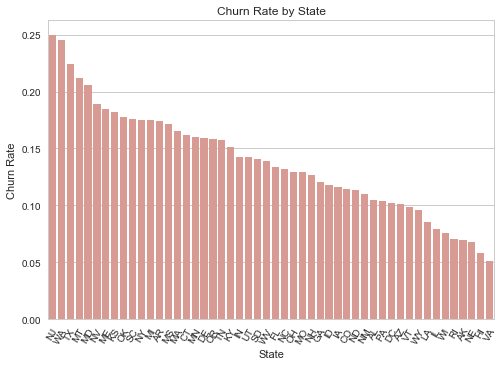

In [181]:
# Write function to get the churn rate
def get_churn_rate(state, data):
    churn    = len(data[(data.state==state) & (data.churn==" True.")])
    no_churn = len(data[(data.state==state) & (data.churn==" False.")])
    if (churn + no_churn) != 0:
        return float(churn)/(churn + no_churn)
    else:
        return 'NaN'

# Make a map of state -> churn rate
states = data.state.unique()
churn_rate = dict()
for state in states:
    churn_rate[state] = get_churn_rate(state, data)
churn_rate = pd.Series(churn_rate)
churn = churn_rate.sort_values(ascending=False)[1:]

# Let's plot the churn rate per state. 
seaborn.set_style("whitegrid")
pl = seaborn.barplot(x=churn.index, y=churn, color="salmon", saturation=.5)
pl.set_ylabel('Churn Rate')
pl.set_xlabel('State')
pl.set_title('Churn Rate by State')
pl.set_xticklabels(churn.index, rotation=60)
seaborn.plt.show()

### Awesome sauce! It's clear that churn rate varies pretty dramatically by state. 
However, as we discussed above, what this isn't taking into account is the actual time until user churn. Thus, in order to continue with this analysis, we will turn to a multivariate Cox model. But first, we need to do a little more data cleaning. 

In [182]:
# Encode categorical data into dummies... here I'm using One-hot encoding. 
bins = ['state', 'int_plan', 'voice_mail', 'churn']
x = pd.get_dummies(columns=bins, data = data, drop_first=True)
# area_code and phone_number seem pretty irrelevant here, or at least containing too many categories. 
# I'll drop them for the time being. 
x.drop(['area_code', 'phone_number'], 1, inplace=True)
x.rename(index=str, columns={'churn_ True.': 'churned'}, inplace=True)
x.head()

,days,num_vmail,tot_day_mins,tot_day_calls,tot_day_charge,tot_eve_mins,tot_eve_calls,tot_eve_charge,tot_night_mins,tot_night_calls,...,state_UT,state_VA,state_VT,state_WA,state_WI,state_WV,state_WY,int_plan_ yes,voice_mail_ yes,churned
0,128.0,25.0,265.1,110.0,45.07,197.4,99.0,16.78,244.7,91.0,...,0,0,0,0,0,0,0,0,1,0
1,107.0,26.0,161.6,123.0,27.47,195.5,103.0,16.62,254.4,103.0,...,0,0,0,0,0,0,0,0,1,0
2,137.0,0.0,243.4,114.0,41.38,121.2,110.0,10.30,162.6,104.0,...,0,0,0,0,0,0,0,0,0,0
3,84.0,0.0,299.4,71.0,50.90,61.9,88.0,5.26,196.9,89.0,...,0,0,0,0,0,0,0,1,0,0
4,75.0,0.0,166.7,113.0,28.34,148.3,122.0,12.61,186.9,121.0,...,0,0,0,0,0,0,0,1,0,0


### Fit a CoxPH model to the entire dataset and evaluate significance of covariates. 

In [183]:
# Use x to fit coxph model of churn using churn True or not as censoring and 'days' as customer 'survival' time. 
cf = ll.CoxPHFitter(penalizer=.1, alpha=.99)
cf.fit(x, 'days', event_col='churned')
cf.print_summary()

n=5000, number of events=707

                           coef  exp(coef)  se(coef)          z         p  lower 0.99  upper 0.99     
num_vmail             5.793e-01  1.785e+00 1.819e-01  3.185e+00 1.448e-03   1.107e-01   1.048e+00   **
tot_day_mins          2.660e-01  1.305e+00 2.236e+00  1.190e-01 9.053e-01  -5.494e+00   6.026e+00     
tot_day_calls         2.358e-02  1.024e+00 3.793e-02  6.216e-01 5.342e-01  -7.413e-02   1.213e-01     
tot_day_charge        2.256e-01  1.253e+00 2.236e+00  1.009e-01 9.196e-01  -5.534e+00   5.985e+00     
tot_eve_mins          7.651e-02  1.080e+00 2.234e+00  3.424e-02 9.727e-01  -5.680e+00   5.833e+00     
tot_eve_calls         2.787e-02  1.028e+00 3.933e-02  7.086e-01 4.786e-01  -7.345e-02   1.292e-01     
tot_eve_charge        1.328e-01  1.142e+00 2.235e+00  5.945e-02 9.526e-01  -5.624e+00   5.889e+00     
tot_night_mins        1.313e-01  1.140e+00 2.231e+00  5.885e-02 9.531e-01  -5.615e+00   5.878e+00     
tot_night_calls       1.676e-02  1.017e+00 

### Note that we are not evaluating the Cox model assumptions here. 
Normally, we would look at residuals (I like Martingale), or run a COXZPH test, which tests the proportional hazards assumption. If we found a covariate that doesn't meet the proportional hazards assumption, we can stratify by it. I am also a big believer in regularization, but I do not believe this package has an intuitive way of doing lasso for shrinkage (my preferred method to do variable selection, which is compatible with Cox models). In any case, we'll move on and take a look at what the above summary means. 
### Using the Cox model to identify significant covariates
Much like multivariate linear models, CoxPH models will result in a likelihood statistic for the beta estimate of each covariate fit in the model, and a corresponding p-value in the multivariate setting. Oftentimes, what is most important to look at is the so-called ***hazard ratio (HR)***, which is simply the exponential of the beta value, or the second column in the above summary. The reason why is that it is more intuitive than the beta value, as it corresponds to the increase in hazard (slope of survival curve) with a corresponding 1-value increase of each particular covariate. Here, I'll simply use the beta value to understand the ***direction*** that the covariate affects the hazard. 

For example, if we set a significance value cutoff of 0.01, the significant covariates with respect to churn are state_CA, state_MT, num_vmail, tot_intl_calls (p < 0.01) and very significant are num_cust_serve_calls, int_plan_yes, and voice_mail_yes (p < 0.001). num_vmail, num_cust_serve_calls, state_CA, state_MT, and int_plan_yes all had positive beta values, indicating that higher values increased churn hazard for customers. Note that MT nor CA were actually the highest churn rate above, indicating that accounting for churn time could possibly have influenced the importances. Either that, or other variables in the model accounted for other states. Some other states with higher churn rates were approaching significance, however, which to some extent gives us some confidence as a sanity check. 

The rest of the significant covariates, i.e. tot_intl_calls and voice_mail_yes, had negative beta values, indicating that increasing values led to lower churn rates.
### Sanity checks and important insights
Of the covariates with positive beta values, the states pass a sanity check, and the number of customer service calls makes intuitive sense, since the more a customer has issues, the more likely they are to drop service. However, the number of voicemails and whether they had an international plan are a little more interesting. Why would a customer having more voicemails lead to higher churn? One possibility is that the voicemail process for the service is not user-friendly or perhaps there are limitations to how many voicemails can be held, so people who get a lot of voicemails need to delete them more frequently than they wanted. Having an international plan is a little more confusing, so I will revisit that in a second. 

In contrast, having a voice mail plan (versus not having one) corresponded to a lower churn rate. This makes the above finding about number of voicemails more confusing, as it probably isn't simply a poor experience with voicemail. I think the thresholding hypothesis may indeed be a factor here, as people tend to "like" the voicemail plan in general. On the other hand, a higher number of international calls corresponded to lower churn rates as well. Perhaps an international plan was pretty expensive, so people who used it a lot didn't churn, but those who used it very little had higher churn because of the additional cost. 

Actionable business insights may already be able to be drawn from this analysis. For example, perhaps certain states could be focused on to try to decrease churn rate (mostly by finding a way to determine *why* those states had higher churn rates. On the other hand, perhaps voicemail needs to be investigated, and whatever the cause of the results above, the policy could be changed to address this. Furthermore, perhaps customers that have international plans but don't frequently use them could be called by the company to see if they wish to cancel the international policy prior to completely canceling the service. 

## Next I will look at how the model predicts. 
Specifically, doing 5-fold cross validation, I use a metric very commonly used in survival analysis to evaluate model performance, i.e. the concordance index (C-index). The C-index simply bootstraps all pairs that can be made from the samples and evaluates whether the predicted "survival" is in the right direction with respect to what you would expect from the true follow up time and censoring status. A C-index of 0.5 would indicate doing no better than random. Greater than 0.5 indicates better than random, while less than 0.5 indicates poorer than random. This can be read kind of like the accuracy of a 2-class logistic model. 

In [184]:
scores = ll.utils.k_fold_cross_validation(cf, x, 'days', event_col='churned', k=5)
print 'Concordance mean = ' + str(round(np.mean(scores), 3)) + ', Standard Dev. = ' + str(round(np.std(scores), 3))

Concordance mean = 0.765, Standard Dev. = 0.017


### The model performs pretty well predictively.
Let's turn to a way of visualizing the predictive value of a model. Kaplan-Meier curves are often used for this. However, they cannot simply be used with the continues survival-expectation output of the CoxPH model. Therefore, here I will binarize the predicted values by the median of all predicted values to create two predicted classes, "low-churn-risk" and "high-churn-risk". Note that for this first pass, I am simply doing this for the model built with all samples, and thus this should not be interpreted as a TRUE prediction, i.e. it is overfit on itself. 

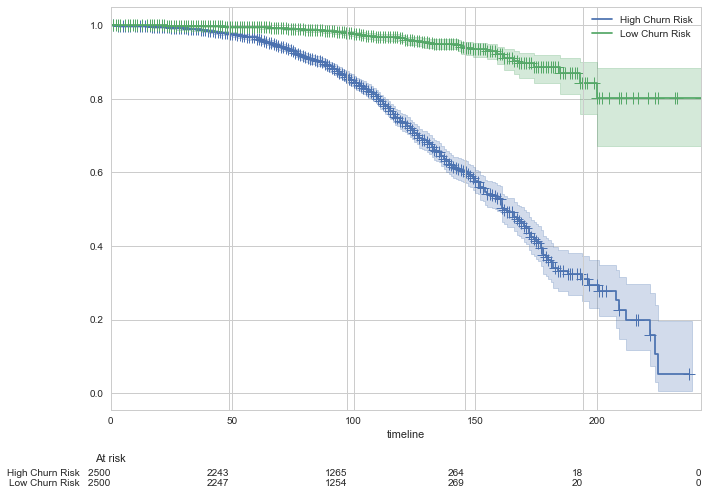

In [185]:
times = cf.predict_expectation(x)
## Plot km curves
# Let's create a function for this so we can do it more efficiently in the future. 
def km_two_class_median(pred_times, data):
    from lifelines.plotting import add_at_risk_counts
    plt.figure(figsize=(10, 7))
    ax = plt.subplot(111)
    
    # Plot of the "high churn risk" group, i.e. those that had an expected churn time lower than the median. 
    criterion = pred_times[0].map(lambda x: x > np.median(pred_times))
    time = data[criterion == False].days
    censor = data[criterion == False].churned
    kmf_time_lt_median = ll.KaplanMeierFitter()
    ax = kmf_time_lt_median.fit(time, censor, label='High Churn Risk').plot(ax=ax, show_censors=True)
    
    # Plot of the "low churn risk" group, i.e. those that had an expected churn time higher than the median. 
    time2 = data[criterion].days
    censor2 = data[criterion].churned
    kmf_time_gt_median = ll.KaplanMeierFitter()
    ax = kmf_time_gt_median.fit(time2, censor2, label='Low Churn Risk').plot(ax=ax, show_censors=True)
    add_at_risk_counts(kmf_time_lt_median, kmf_time_gt_median, ax=ax)
    plt.show()

# Now plot the true survival times, split into binary groups by median of the predicted survival times (risk groups)
# Note that this is very 'overfit' because the prediction was made using data that the model was built on. 
# Thus, need to do the same with a hold-out set. 
km_two_class_median(times, x)
# cf.predict_survival_function(x).plot(ax=ax, show_censors=True)

Note that the y-axis is the "survival" rate. Kaplan Meier curves will drop off every time a non-censored sample has an event. The censored datapoints are indicated by "+"s. It is clear that the "predicted" high-risk customers had a MUCH more dramatic dropoff over time, especially after the 100 day mark. In fact, customer retention in the low-churn-risk group was well over 90% but retention in the high-churn-risk group was only 60% after 150 days. 

Also note that since the slope of the survival functions seem to not be perfectly constant over time, we may be violating assumptions for the model. But addressing this is definitely more appropriate for an additional post. 

Next, let's see what this curve looks like when we actually have a hold-out set that we are predicting survival on using a new Cox model. 

(4000, 68) (1000, 68)
Concordance mean = 0.758, Standard Dev. = 0.026


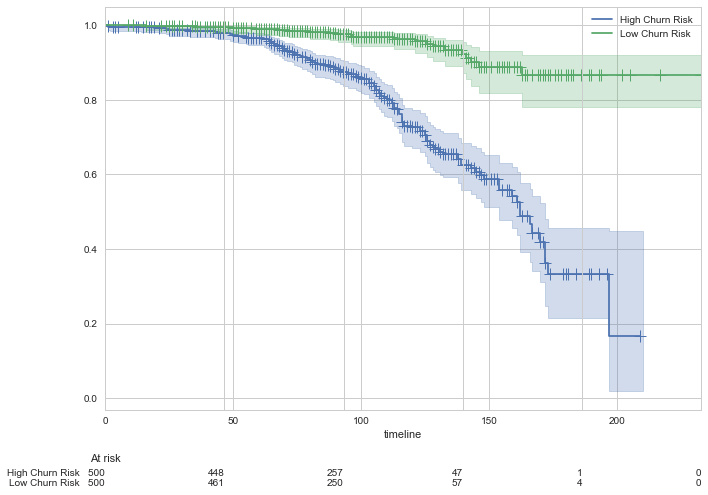

In [186]:
## Split the data into training and test sets
train, test = train_test_split(x, test_size=0.2)
print train.shape, test.shape

# Build new coxph model on training data 
cf_tr = ll.CoxPHFitter(penalizer=.1, alpha=.99)
cf_tr.fit(train, 'days', event_col='churned')
# CV scores
scores = ll.utils.k_fold_cross_validation(cf_tr, train, 'days', event_col='churned', k=5)
print 'Concordance mean = ' + str(round(np.mean(scores), 3)) + ', Standard Dev. = ' + str(round(np.std(scores), 3))
# Predict in test set and plot KM curve
pred_ts = cf_tr.predict_expectation(test)
km_two_class_median(pred_ts, test)

### Model predicts high- versus low-risk well
It is clear that the data is consistent enough that this didn't affect the model performance, which is good. 

In real practice, it should be noted that the cutoff for stratifying into risk groups is normally chosen in the training set as well. For survival models, Martingale residuals can be used for finding a binarization point (if you are interested in how, shoot me an email). But in practice, it may also be generally useful to output a continuous value for churn risk or expectation. This could be used to find individuals that can be targeted with campaigns intended to increase their retention. 

Continuous predicted survival values can be compared to the true survival function itself. Plotting out the curve for the predicted survival function is done with the following code, but is not currently working in Python for some reason. 
plt.figure(figsize=(10, 7))
ax = plt.subplot()
cf.predict_survival_function(x).plot(ax=ax)
plt.show()

A last note to make is that oftentimes a super relevant component of churn analysis, as alluded to above, is to determine how churn changes over time. I found an *awesome* post that argues that you can add time of customer signup as an interaction term to account for this, which can help you to determine if correcting for time reduces the significance of each particular covariate. Take a look-see! http://daynebatten.com/2016/01/customer-churn-time-dependent-coefficients/